In [ ]:
import os
import cv2
import shutil
import time
import json


def vidToFrame(vid_file,out_dir):


    video_capture = cv2.VideoCapture(vid_file)

    output_folder = out_dir
    #shutil.rmtree(output_folder)
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Initialize frame count and flag
    vid_cnt = 0
    success = True



    # Read the next frame
    #success, frame = video_capture.read()

    
    frame_count=0
    while frame_count < 48:
        
        frame_count += 1
        success, frame = video_capture.read()
        frame_path = os.path.join(output_folder, f"frame_{frame_count}.jpg")

        if frame is not None:
            cv2.imwrite(frame_path, frame)

        
#        cv2.imshow('frame', frame)
        
        if cv2.waitKey(20) & 0xFF == ord('q') :
            break

    # Release the video capture object
    video_capture.release()
    cv2.destroyAllWindows()





file_path = '/kaggle/input/wlasl-processed/WLASL_v0.3.json'
missing_file_path = '/kaggle/input/wlasl-processed//missing.txt'
videos_dir = '/kaggle/input/wlasl-processed/videos/'

# Load the WLASL dataset
with open(file_path) as file:
    wlasl = json.load(file)

# Read the missing video IDs from the file
with open(missing_file_path, 'r') as file:
    missing_videos = file.read().splitlines()

# Specify the base directory for the dataset
dataset_dir = '/kaggle/working/Dataset/frames'

# Create necessary directories
os.makedirs(dataset_dir, exist_ok=True)
os.makedirs(os.path.join(dataset_dir, 'Train'), exist_ok=True)
os.makedirs(os.path.join(dataset_dir, 'Test'), exist_ok=True)

# Process each class in the WLASL dataset
for class_data in wlasl:
    class_name = class_data['gloss']
    print(class_name)
    
    for instance in class_data['instances']:
        video_id = instance['video_id']
        
        if video_id not in missing_videos:
            video_file = os.path.join(videos_dir, video_id + '.mp4')
    
            if instance['split'] == 'train':
                train_dir = os.path.join(dataset_dir, 'Train', class_name, video_id)
                os.makedirs(train_dir, exist_ok=True)
                vidToFrame(video_file, train_dir)
                print('train', video_id)
            else:
                test_dir = os.path.join(dataset_dir, 'Test', class_name, video_id)
                os.makedirs(test_dir, exist_ok=True)
                vidToFrame(video_file, test_dir)
                print('test', video_id)


100%|██████████| 144/144 [24:28<00:00, 10.20s/it]


['drive' 'you' 'father' 'off' 'cow' 'tired' 'pants' 'christmas' 'north'
 'laugh' 'most' 'green' 'who' 'champion' 'hard' 'show' 'late' 'approve'
 'elephant' 'study' 'alone' 'city' 'go' 'water' 'bar' 'cute' 'call'
 'perspective' 'clothes' 'before' 'decorate' 'student' 'school' 'trade'
 'language' 'daughter' 'behind' 'yesterday' 'dress' 'home' 'train' 'what'
 'office' 'year' 'divorce' 'cookie' 'thanksgiving' 'feel' 'car' 'throw'
 'woman' 'jacket' 'paint' 'jump' 'inform' 'silly' 'bath' 'share'
 'practice' 'problem' 'milk' 'win' 'basement' 'basketball' 'africa'
 'business' 'man' 'hearing' 'knife' 'walk' 'right' 'good' 'cry' 'crazy'
 'new' 'hope' 'secretary' 'far' 'class' 'vote' 'environment' 'none' 'all'
 'book' 'ride' 'forget' 'some' 'movie' 'rabbit' 'government' 'like'
 'write' 'flower' 'pencil' 'thursday' 'ok' 'teach' 'moon' 'close' 'party'
 'run' 'corn' 'name' 'afternoon' 'birthday' 'temperature' 'save' 'work'
 'read' 'fine' 'nephew' 'time' 'lose' 'join' 'sweet' 'cut' 'fast' 'dive'
 'ch

100%|██████████| 144/144 [00:01<00:00, 127.39it/s]


(685, 48, 225)
(685, 144)
(172, 48, 225)
(172, 144)


100%|██████████| 144/144 [00:00<00:00, 292.67it/s]


(369, 48, 225)
(369, 144)
Epoch 1/100
22/22 [==============================] - 18s 114ms/step - loss: 4.9826 - categorical_accuracy: 0.0088 - val_loss: 4.9885 - val_categorical_accuracy: 0.0116
Epoch 2/100
22/22 [==============================] - 1s 24ms/step - loss: 4.9596 - categorical_accuracy: 0.0088 - val_loss: 4.9755 - val_categorical_accuracy: 0.0058
Epoch 3/100
22/22 [==============================] - 1s 24ms/step - loss: 4.9319 - categorical_accuracy: 0.0219 - val_loss: 4.9748 - val_categorical_accuracy: 0.0174
Epoch 4/100
22/22 [==============================] - 1s 24ms/step - loss: 4.8760 - categorical_accuracy: 0.0161 - val_loss: 4.9344 - val_categorical_accuracy: 0.0291
Epoch 5/100
22/22 [==============================] - 1s 25ms/step - loss: 4.7588 - categorical_accuracy: 0.0190 - val_loss: 4.8934 - val_categorical_accuracy: 0.0291
Epoch 6/100
22/22 [==============================] - 1s 24ms/step - loss: 4.6397 - categorical_accuracy: 0.0219 - val_loss: 4.7991 - val_categ

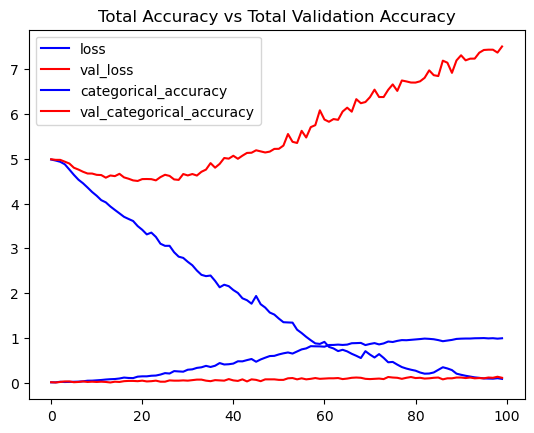

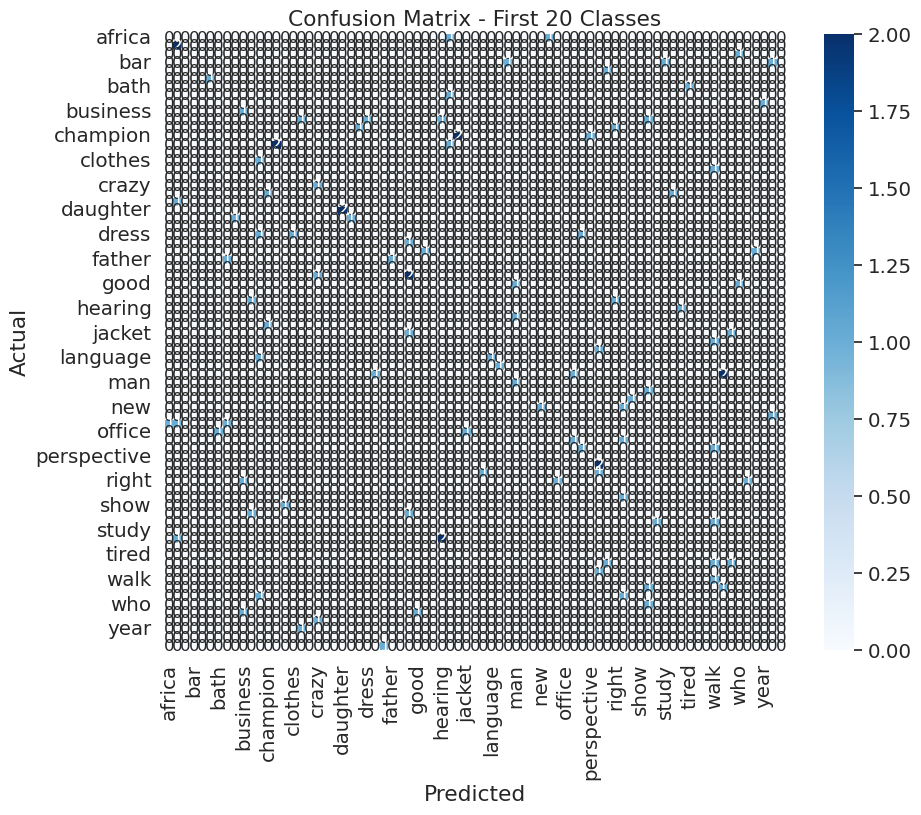

In [35]:
import mediapipe as mp
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import os
import shutil
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import glob
import cv2
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense
from keras.callbacks import EarlyStopping
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
np.random.seed(42)



# Create a Holistic object to detect pose, face, and hands keypoints
mp_holistic = mp.solutions.holistic

# Drawing utilities
mp_drawing = mp.solutions.drawing_utils

def mediapipe_detection(image, model):
    if image is None:
        raise ValueError(f"Failed to load image: {image}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

def draw_styled_landmarks(image, results):

    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             )
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             )
    # Draw right hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             )

def adjust_landmarks(arr,center):

    # Reshape the array to have shape (n, 3)
    arr_reshaped = arr.reshape(-1, 3)

    # Repeat the center array to have shape (n, 3)
    center_repeated = np.tile(center, (len(arr_reshaped), 1))

    # Subtract the center array from the arr array
    arr_adjusted = arr_reshaped - center_repeated

    # Reshape arr_adjusted back to shape (n*3,)
    arr_adjusted = arr_adjusted.reshape(-1)
    return(arr_adjusted)

def extract_keypoints(results):

    pose = np.array([[res.x, res.y, res.z] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    nose=pose[:3]
    lh_wrist=lh[:3]
    rh_wrist=rh[:3]
    pose_adjusted = adjust_landmarks(pose,nose)
    lh_adjusted = adjust_landmarks(lh,lh_wrist)
    rh_adjusted = adjust_landmarks(rh,rh_wrist)
    return pose_adjusted, lh_adjusted, rh_adjusted

selected_words = os.listdir('/kaggle/working/Dataset/frames/Train')

def make_keypoint_arrays(path,split):

    os.makedirs('/kaggle/working/Dataset/npy_arrays',exist_ok = True)
    os.makedirs(f'/kaggle/working/Dataset/npy_arrays/{split}',exist_ok = True)
    working_path = f'/kaggle/working/Dataset/npy_arrays/{split}'
    words_folder = os.path.join(path, split)
    selected_words1=[]
    for words1 in selected_words:
        npy_fold = os.listdir(os.path.join(working_path))
        if words1 not in npy_fold:
            selected_words1.append(words1)
    i=1
    # Loop through all the subfolders in the folder
    for word in tqdm(selected_words1):
        npy_fold = os.listdir(os.path.join(working_path))
        if word not in npy_fold:
            video_files = os.listdir(os.path.join(words_folder, word))
              # Loop through the video files
            for video_file in video_files:
                    # Open the video file
                video = sorted(os.listdir(os.path.join(words_folder, word, video_file)))
        
                # Initialize the list of keypoints for this video
                pose_keypoints, lh_keypoints, rh_keypoints = [], [], []
                with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
                  # Loop through the video frames
                  for frame in video:
                      # Perform any necessary preprocessing on the frame (e.g., resizing, normalization)
                    frame = os.path.join(words_folder, word, video_file,frame)
                    frame = cv2.imread(frame)
        #                 frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    
                      # Normalize pixel values to the range [0, 1]
                    # Make detections
                    image, results = mediapipe_detection(frame, holistic)
        
                    # Extract keypoints
                    pose, lh, rh = extract_keypoints(results)
                    # Add the keypoints to the list for this video
                    pose_keypoints.append(pose)
                    lh_keypoints.append(lh)
                    rh_keypoints.append(rh)           
                    # Save the keypoints for this video to a numpy array
                    pose_directory = os.path.join(working_path, word,'pose_keypoints')
                    lh_directory = os.path.join(working_path, word,'lh_keypoints')
                    rh_directory = os.path.join(working_path, word,'rh_keypoints')
        
                    if not os.path.exists(pose_directory):
                        os.makedirs(pose_directory)
        
                    if not os.path.exists(lh_directory):
                        os.makedirs(lh_directory)
        
                    if not os.path.exists(rh_directory):
                        os.makedirs(rh_directory)
        
                    pose_path = os.path.join(pose_directory, video_file)
                    np.save(pose_path, pose_keypoints)
        
                    lh_path = os.path.join(lh_directory, video_file)
                    np.save(lh_path, lh_keypoints)
        
                    rh_path = os.path.join(rh_directory, video_file)
                    np.save(rh_path, rh_keypoints)

make_keypoint_arrays('/kaggle/working/Dataset/frames','Train/')
make_keypoint_arrays('/kaggle/working/Dataset/frames','Test/')

words= np.array(os.listdir('/kaggle/working/Dataset/frames/Train'))
print(words)

label_map = {label:num for num, label in enumerate(words)}
print(label_map)

def preprocess_data(data_path,split,f_avg):

    # Initialize the lists of sequences and labels
    sequences = []
    labels = []
    
    # Iterate over the words
    for word in tqdm(words):
        word_path = os.path.join(data_path, split, word)
        word_id = os.path.basename(word_path).zfill(4)
    
        lh_keypoints_folder = os.path.join(word_path, "lh_keypoints")
        rh_keypoints_folder = os.path.join(word_path, "rh_keypoints")
        pose_keypoints_folder = os.path.join(word_path, "pose_keypoints")
    
        # Iterate through the sequences (numpy arrays) contained in the lh_keypoints folder
        for sequence in os.listdir(lh_keypoints_folder):
            # Load the left hand array
            res_lh = np.load(os.path.join(lh_keypoints_folder, sequence))
    
            # Determine how many frames to select
            num_frames = min(res_lh.shape[0], f_avg)
            res_lh = res_lh[:num_frames, :]
            while num_frames < f_avg:
                res_lh = np.concatenate((res_lh, np.expand_dims(res_lh[-1, :], axis=0)), axis=0)
                num_frames += 1
    
            # Load the right hand array
            res_rh = np.load(os.path.join(rh_keypoints_folder, sequence))
    
            # Determine how many frames to select
            num_frames = min(res_rh.shape[0], f_avg)
            res_rh = res_rh[:num_frames, :]
            while num_frames < f_avg:
                res_rh = np.concatenate((res_rh, np.expand_dims(res_rh[-1, :], axis=0)), axis=0)
                num_frames += 1
    
            # Load the pose array
            res_pose = np.load(os.path.join(pose_keypoints_folder, sequence))
    
            # Determine how many frames to select
            num_frames = min(res_pose.shape[0], f_avg)
            res_pose = res_pose[:num_frames, :]
            while num_frames < f_avg:
                res_pose = np.concatenate((res_pose, np.expand_dims(res_pose[-1, :], axis=0)), axis=0)
                num_frames += 1
    
            # Append the subsequence to the list of sequences
            sequences.append(np.concatenate((res_pose, res_lh, res_rh), axis=1))
            # Append the label to the list of labels
            labels.append(label_map[word])
    
    # Convert the lists of sequences and labels to numpy arrays
    X = np.array(sequences)
    y = to_categorical(labels).astype(int)
    
    return X, y

#train and validation splits
data_path = '/kaggle/working/Dataset/npy_arrays'

X_train,y_train=preprocess_data(data_path,'Train/',48)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

#test split
X_test,y_test=preprocess_data(data_path,'Test',48)

print(X_test.shape)
print(y_test.shape)

# Define the Bidirectional LSTM model with Attention
model = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(len(words), activation='softmax')
])

# Compile the model

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Set up early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Metric to monitor for early stopping
    mode='min',  # Set mode to 'min' for minimizing the metric
    patience=5,  # Number of epochs with no improvement before stopping
    restore_best_weights=True,  # Restore the best model weights
    verbose=1
)

model_training_history = model.fit(X_train, y_train, batch_size=32, validation_data=(X_val,y_val), validation_batch_size=32, epochs=100)

# Evaluate the model on train data
model_evaluation_history = model.evaluate(X_train, y_train)

# Evaluate the model on test data
model_evaluation_history = model.evaluate(X_test, y_test)

def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):


    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

# Visualize the training and validation loss metrices.
plot_metric(model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

# Visualize the training and validation accuracy metrices.
plot_metric(model_training_history, 'categorical_accuracy', 'val_categorical_accuracy', 'Total Accuracy vs Total Validation Accuracy')

#Predicted sign
res = model.predict(X_test)
words[np.argmax(res[1])]

#Real sign
words[np.argmax(y_test[1])]

# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'ASL_Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

os.makedirs('/kaggle/working/Model',exist_ok=True)
# Save your Model.
model.save(f'/kaggle/working/Model/{model_file_name}')

yhat = model.predict(X_test)

def get_key_by_value(dictionary, value):
    for key, val in dictionary.items():
        if val == value:
            return key
    return None

ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

y = []
for v in ytrue:
    y.append(get_key_by_value(label_map, v))
print(y)



ypred = []
for v in yhat:
    ypred.append(get_key_by_value(label_map, v))
print(ypred)



from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y and ypred are your target labels and predicted labels, respectively

# Select the first 20 classes
y_subset = y[:200]
ypred_subset = ypred[:200]

# Get unique class labels
class_labels = np.unique(y_subset)

# Compute confusion matrix
cm = confusion_matrix(y_subset, ypred_subset, labels=class_labels)

# Create a DataFrame from the confusion matrix
df_cm = pd.DataFrame(cm, index=class_labels, columns=class_labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.3)  # for label size
sns.heatmap(df_cm, cmap="Blues", annot=True, fmt="d", annot_kws={"size": 12})
plt.title("Confusion Matrix - First 20 Classes")
plt.show()



In [24]:
import os
import shutil
ld=os.listdir('/kaggle/working/Dataset/frames/Test')
ld_=os.listdir('/kaggle/working/Dataset/frames/Train')
#for elem in ld[150:]:
    #shutil.rmtree(os.path.join(f'/kaggle/working/Dataset/frames/Test/',elem))
    #shutil.rmtree(os.path.join(f'/kaggle/working/Dataset/frames/Test/',elem))
for elem in ld_:
    if elem not in ld:
        shutil.rmtree(os.path.join(f'/kaggle/working/Dataset/frames/Train/',elem))
print(len(ld_))        

144


In [34]:
tr=os.listdir('/kaggle/working/Dataset/frames/Train/')
te=os.listdir('/kaggle/working/Dataset/frames/Test/')
print(len(tr),len(te))
for elem in tr:
    if elem not in te:
        print(elem)

144 144
